# 🤖 Suivi du Projet Machine Learning - Segmentation Clients
## Prédiction de Réponse aux Campagnes Marketing

**Objectif :** Construire un modèle prédictif pour prédire la probabilité qu'un client réponde à une campagne future.

**Dataset :** ML_DataSet.csv (2237 clients × 49 features)

**Cible :** Reponse_Derniere_Campagne (0/1)

---

## 📊 Phase 1 : Exploration et Préparation des Données

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Bibliothèques importées avec succès")
print(f"📅 Date de dernière mise à jour : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Bibliothèques importées avec succès
📅 Date de dernière mise à jour : 2025-10-17 10:08:53


In [3]:
# Chargement du dataset
df = pd.read_csv('ML_DataSet.csv')

print("=" * 70)
print("INFORMATIONS GÉNÉRALES DU DATASET")
print("=" * 70)
print(f"Nombre de lignes (clients) : {df.shape[0]}")
print(f"Nombre de colonnes (features) : {df.shape[1]}")
print(f"Taille mémoire : {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 70)

# Aperçu des données
df.head()

INFORMATIONS GÉNÉRALES DU DATASET
Nombre de lignes (clients) : 2237
Nombre de colonnes (features) : 49
Taille mémoire : 1.61 MB



,ID_Client,Annee_Naissance,Niveau_Education,Statut_Marital,Revenu,Enfants_Maison,Ados_Maison,Date_Inscription,Jours_Dernier_Achat,Achat_Vins,Achat_Fruits,Achat_Viandes,Achat_Poissons,Achat_Produits_Sucres,Achat_Produits_Or,Achats_Promotions,Achats_En_Ligne,Achats_Catalogue,Achats_En_Magasin,Visites_Web_Mois,Reponse_Campagne_3,Reponse_Campagne_4,Reponse_Campagne_5,Reponse_Campagne_1,Reponse_Campagne_2,Plainte,Cout_Contact_Z,Revenus_Z,Reponse_Derniere_Campagne,Statut_Marital_Texte,Total_Depense,Total_Achats,Depense_Moy_Par_Achat,Total_Campagnes_Acceptees,Jour_Inscription,Revenu_Moyen_Mois,Age_Inscription,Categorie_Age,Niveau_Education_Encode,Statut_Marital_Encode,Jour_Inscription_Encode,Categorie_Age_Encode,Total_Enfants,A_Des_Enfants,Ratio_Vins,Ratio_Viandes,Taux_Reponse_Historique,Engagement_Web,Sensibilite_Promo
0,5524,1957,Graduation,single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,Single,1617,22,64.680000,0,Tuesday,4844.833333,55,Senior (51-65),2,0,5,3,0,0,0.392703,0.337662,0.0,0.363636,0.136364
1,2174,1954,Graduation,single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,Single,27,4,4.500000,0,Saturday,3862.000000,60,Senior (51-65),2,0,2,3,2,1,0.407407,0.222222,0.0,0.250000,0.500000
2,4141,1965,Graduation,couple,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,Together,776,20,36.952381,0,Wednesday,5967.750000,48,Adulte confirmé (36-50),2,1,6,2,0,0,0.548969,0.163660,0.0,0.400000,0.050000
3,6182,1984,Graduation,couple,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,Together,53,6,6.625000,0,Monday,2220.500000,30,Adulte (26-35),2,1,1,1,1,1,0.207547,0.377358,0.0,0.333333,0.333333
4,5324,1981,PhD,couple,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,Married,422,14,22.210526,0,Sunday,4857.750000,33,Adulte (26-35),4,1,3,1,1,1,0.409953,0.279621,0.0,0.357143,0.357143


### 🎯 Analyse de la Variable Cible

DISTRIBUTION DE LA VARIABLE CIBLE
Variable : Reponse_Derniere_Campagne

  Classe 0 : 1903 clients (85.07%)
  Classe 1 :  334 clients (14.93%)

⚠️  Ratio de déséquilibre : 5.70:1
   → Déséquilibre IMPORTANT détecté
   → Stratégie recommandée : scale_pos_weight, class_weight, ou SMOTE


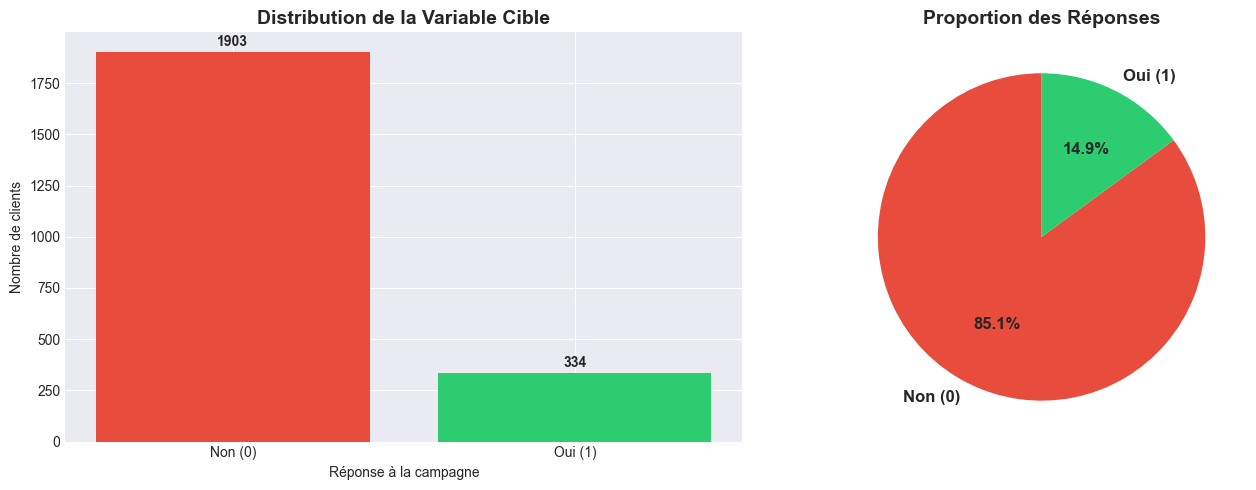


✅ Analyse de la variable cible terminée


In [4]:
# Distribution de la variable cible
target_col = 'Reponse_Derniere_Campagne'
target_dist = df[target_col].value_counts()
target_pct = df[target_col].value_counts(normalize=True) * 100

print("=" * 70)
print("DISTRIBUTION DE LA VARIABLE CIBLE")
print("=" * 70)
print(f"Variable : {target_col}\n")
for classe in sorted(df[target_col].unique()):
    count = target_dist[classe]
    pct = target_pct[classe]
    print(f"  Classe {classe} : {count:4d} clients ({pct:.2f}%)")

ratio_desequilibre = target_dist[0] / target_dist[1]
print(f"\n⚠️  Ratio de déséquilibre : {ratio_desequilibre:.2f}:1")
if ratio_desequilibre > 3:
    print("   → Déséquilibre IMPORTANT détecté")
    print("   → Stratégie recommandée : scale_pos_weight, class_weight, ou SMOTE")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot
axes[0].bar(['Non (0)', 'Oui (1)'], target_dist.values, color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Distribution de la Variable Cible', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre de clients')
axes[0].set_xlabel('Réponse à la campagne')
for i, v in enumerate(target_dist.values):
    axes[0].text(i, v + 30, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#e74c3c', '#2ecc71']
axes[1].pie(target_dist.values, labels=['Non (0)', 'Oui (1)'], autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Proportion des Réponses', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Analyse de la variable cible terminée")

### 📋 Sélection des Features pour le Modèle

In [5]:
# Colonnes à exclure du modèle
colonnes_a_exclure = [
    'ID_Client',                      # Identifiant
    'Annee_Naissance',                # Redondant avec Age_Inscription
    'Date_Inscription',               # Format date, redondant avec Jour_Inscription_Encode
    'Niveau_Education',               # Redondant avec Niveau_Education_Encode
    'Statut_Marital',                 # Redondant avec Statut_Marital_Encode
    'Statut_Marital_Texte',           # Redondant
    'Jour_Inscription',               # Redondant avec Jour_Inscription_Encode
    'Categorie_Age',                  # Redondant avec Categorie_Age_Encode
    'Cout_Contact_Z',                 # Constante (toujours 3)
    'Revenus_Z',                      # Constante (toujours 11)
    'Reponse_Derniere_Campagne',     # TARGET (à extraire séparément)
    'Enfants_Maison',                 # Redondant avec Total_Enfants
    'Ados_Maison'                     # Redondant avec Total_Enfants
]

print("=" * 70)
print("PRÉPARATION DES FEATURES")
print("=" * 70)
print(f"\nColonnes totales : {len(df.columns)}")
print(f"Colonnes à exclure : {len(colonnes_a_exclure)}")
print(f"Colonnes pour le modèle : {len(df.columns) - len(colonnes_a_exclure)}")

# Créer X et y
X = df.drop(columns=colonnes_a_exclure)
y = df['Reponse_Derniere_Campagne']

print(f"\n✅ X shape : {X.shape}")
print(f"✅ y shape : {y.shape}")

print("\n--- FEATURES SÉLECTIONNÉES ---")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

# Vérifier les valeurs manquantes
missing = X.isnull().sum()
if missing.sum() > 0:
    print("\n⚠️  Valeurs manquantes détectées :")
    print(missing[missing > 0])
else:
    print("\n✅ Aucune valeur manquante détectée")

PRÉPARATION DES FEATURES

Colonnes totales : 49
Colonnes à exclure : 13
Colonnes pour le modèle : 36

✅ X shape : (2237, 36)
✅ y shape : (2237,)

--- FEATURES SÉLECTIONNÉES ---
 1. Revenu
 2. Jours_Dernier_Achat
 3. Achat_Vins
 4. Achat_Fruits
 5. Achat_Viandes
 6. Achat_Poissons
 7. Achat_Produits_Sucres
 8. Achat_Produits_Or
 9. Achats_Promotions
10. Achats_En_Ligne
11. Achats_Catalogue
12. Achats_En_Magasin
13. Visites_Web_Mois
14. Reponse_Campagne_3
15. Reponse_Campagne_4
16. Reponse_Campagne_5
17. Reponse_Campagne_1
18. Reponse_Campagne_2
19. Plainte
20. Total_Depense
21. Total_Achats
22. Depense_Moy_Par_Achat
23. Total_Campagnes_Acceptees
24. Revenu_Moyen_Mois
25. Age_Inscription
26. Niveau_Education_Encode
27. Statut_Marital_Encode
28. Jour_Inscription_Encode
29. Categorie_Age_Encode
30. Total_Enfants
31. A_Des_Enfants
32. Ratio_Vins
33. Ratio_Viandes
34. Taux_Reponse_Historique
35. Engagement_Web
36. Sensibilite_Promo

⚠️  Valeurs manquantes détectées :
Depense_Moy_Par_Achat   

### 📊 Statistiques Descriptives des Features

In [6]:
# Statistiques descriptives
print("=" * 70)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 70)

X.describe().T

STATISTIQUES DESCRIPTIVES


,count,mean,std,min,25%,50%,75%,max
Revenu,2237.0,51676.153330,25615.057625,0.000000,34704.000000,51039.000000,68281.000000,666666.000000
Jours_Dernier_Achat,2237.0,49.104604,28.956073,0.000000,24.000000,49.000000,74.000000,99.000000
Achat_Vins,2237.0,303.995530,336.574382,0.000000,24.000000,174.000000,504.000000,1493.000000
Achat_Fruits,2237.0,26.270451,39.715972,0.000000,1.000000,8.000000,33.000000,199.000000
Achat_Viandes,2237.0,166.916853,225.661158,0.000000,16.000000,67.000000,232.000000,1725.000000
Achat_Poissons,2237.0,37.523022,54.639909,0.000000,3.000000,12.000000,50.000000,259.000000
Achat_Produits_Sucres,2237.0,27.068842,41.293949,0.000000,1.000000,8.000000,33.000000,263.000000
Achat_Produits_Or,2237.0,43.968708,52.054318,0.000000,9.000000,24.000000,56.000000,362.000000
Achats_Promotions,2237.0,2.326777,1.932923,0.000000,1.000000,2.000000,3.000000,15.000000
Achats_En_Ligne,2237.0,4.087170,2.779461,0.000000,2.000000,4.000000,6.000000,27.000000


### 🔍 Analyse de Corrélation avec la Cible

TOP 15 FEATURES CORRÉLÉES AVEC LA CIBLE
Taux_Reponse_Historique      0.426253
Total_Campagnes_Acceptees    0.426253
Reponse_Campagne_5           0.328182
Reponse_Campagne_1           0.293882
Total_Depense                0.265726
Reponse_Campagne_3           0.254144
Achat_Vins                   0.247392
Achat_Viandes                0.236640
Achats_Catalogue             0.220894
Reponse_Campagne_4           0.176890
Reponse_Campagne_2           0.169249
Total_Achats                 0.164408
Depense_Moy_Par_Achat        0.160218
Achats_En_Ligne              0.148453
Achat_Produits_Or            0.140693
Name: Target, dtype: float64

TOP 15 FEATURES NÉGATIVEMENT CORRÉLÉES
Ratio_Viandes              0.095660
Engagement_Web             0.051828
Achats_En_Magasin          0.038855
Jour_Inscription_Encode    0.006022
Achats_Promotions          0.001854
Plainte                    0.000185
Visites_Web_Mois          -0.004449
Ratio_Vins                -0.005664
Categorie_Age_Encode      -0.0165

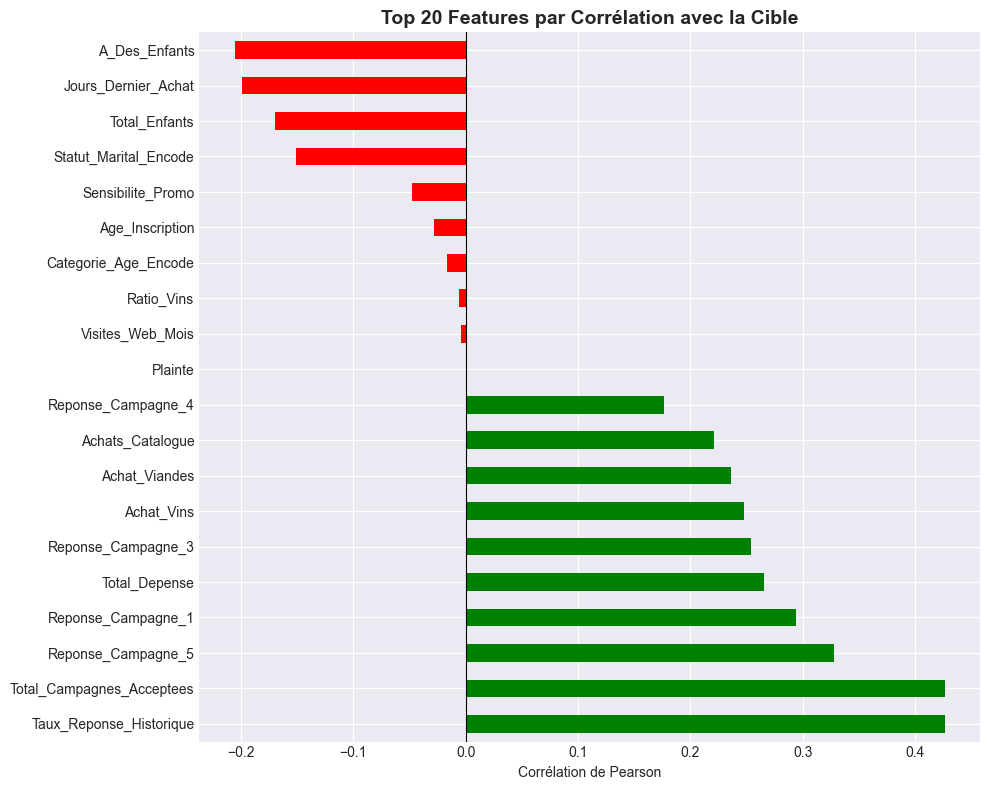


✅ Analyse de corrélation terminée


In [7]:
# Corrélation avec la variable cible
df_with_target = X.copy()
df_with_target['Target'] = y

correlations = df_with_target.corr()['Target'].drop('Target').sort_values(ascending=False)

print("=" * 70)
print("TOP 15 FEATURES CORRÉLÉES AVEC LA CIBLE")
print("=" * 70)
print(correlations.head(15))

print("\n" + "=" * 70)
print("TOP 15 FEATURES NÉGATIVEMENT CORRÉLÉES")
print("=" * 70)
print(correlations.tail(15))

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))
top_features = pd.concat([correlations.head(10), correlations.tail(10)])
colors = ['green' if x > 0 else 'red' for x in top_features.values]
top_features.plot(kind='barh', ax=ax, color=colors)
ax.set_title('Top 20 Features par Corrélation avec la Cible', fontsize=14, fontweight='bold')
ax.set_xlabel('Corrélation de Pearson')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\n✅ Analyse de corrélation terminée")

---
## 🤖 Phase 2 : Construction et Évaluation des Modèles

### Modèles à tester :
1. **Régression Logistique** (baseline)
2. **Random Forest** (robuste)
3. **XGBoost** (champion attendu)

In [8]:
# Imports pour le machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    f1_score,
    accuracy_score
)

try:
    from xgboost import XGBClassifier
    xgboost_available = True
    print("✅ XGBoost disponible")
except Exception as e:
    xgboost_available = False
    print(f"⚠️  XGBoost non disponible: {str(e)[:100]}")
    print("   Le notebook continuera avec Logistic Regression et Random Forest")

print("✅ Bibliothèques ML importées avec succès")

✅ XGBoost disponible
✅ Bibliothèques ML importées avec succès


### 🔀 Split Train/Test avec Stratification

In [9]:
# Split stratifié (important pour le déséquilibre)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintient les proportions
)

print("=" * 70)
print("SPLIT TRAIN/TEST")
print("=" * 70)
print(f"Train set : {X_train.shape[0]} clients ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set  : {X_test.shape[0]} clients ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nDistribution dans Train set :")
print(y_train.value_counts())
print(f"Ratio : {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

print("\nDistribution dans Test set :")
print(y_test.value_counts())
print(f"Ratio : {y_test.value_counts()[0] / y_test.value_counts()[1]:.2f}:1")

# Normalisation (utile pour Régression Logistique)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Données préparées pour l'entraînement")

SPLIT TRAIN/TEST
Train set : 1789 clients (80.0%)
Test set  : 448 clients (20.0%)

Distribution dans Train set :
Reponse_Derniere_Campagne
0    1522
1     267
Name: count, dtype: int64
Ratio : 5.70:1

Distribution dans Test set :
Reponse_Derniere_Campagne
0    381
1     67
Name: count, dtype: int64
Ratio : 5.69:1

✅ Données préparées pour l'entraînement


In [10]:
# Gestion des valeurs manquantes
print("=" * 70)
print("GESTION DES VALEURS MANQUANTES")
print("=" * 70)

# Vérifier les valeurs manquantes dans X_train
missing_train = X_train.isnull().sum()
if missing_train.sum() > 0:
    print(f"\n⚠️  Valeurs manquantes détectées dans X_train :")
    print(missing_train[missing_train > 0])
    
    # Imputation : remplacer les NaN par la médiane
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    
    # Transformer X_train et X_test
    X_train = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    X_test = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    print(f"\n✅ Valeurs manquantes imputées avec la médiane")
    print(f"   Valeurs manquantes restantes dans X_train : {X_train.isnull().sum().sum()}")
    print(f"   Valeurs manquantes restantes dans X_test : {X_test.isnull().sum().sum()}")
else:
    print("\n✅ Aucune valeur manquante détectée")

# Re-normaliser après imputation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Données préparées et normalisées")

GESTION DES VALEURS MANQUANTES

⚠️  Valeurs manquantes détectées dans X_train :
Depense_Moy_Par_Achat    3
dtype: int64

✅ Valeurs manquantes imputées avec la médiane
   Valeurs manquantes restantes dans X_train : 0
   Valeurs manquantes restantes dans X_test : 0

✅ Données préparées et normalisées


### 📊 Fonction d'Évaluation des Modèles

In [11]:
def evaluer_modele(model, X_train, X_test, y_train, y_test, nom_modele):
    """
    Évalue un modèle et affiche les métriques complètes
    """
    print("\n" + "=" * 70)
    print(f"ÉVALUATION : {nom_modele}")
    print("=" * 70)
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n📊 Métriques Globales :")
    print(f"  Accuracy  : {accuracy:.4f}")
    print(f"  F1-Score  : {f1:.4f}")
    print(f"  ROC-AUC   : {roc_auc:.4f}")
    
    print(f"\n📋 Rapport de Classification :")
    print(classification_report(y_test, y_pred, target_names=['Non (0)', 'Oui (1)']))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Non (0)', 'Oui (1)'],
                yticklabels=['Non (0)', 'Oui (1)'])
    axes[0].set_title(f'Matrice de Confusion - {nom_modele}', fontweight='bold')
    axes[0].set_ylabel('Vraie Classe')
    axes[0].set_xlabel('Classe Prédite')
    
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'{nom_modele} (AUC = {roc_auc:.3f})', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
    axes[1].set_xlabel('Taux de Faux Positifs')
    axes[1].set_ylabel('Taux de Vrais Positifs')
    axes[1].set_title(f'Courbe ROC - {nom_modele}', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("✅ Fonction d'évaluation créée")

✅ Fonction d'évaluation créée


---
## 🎯 À COMPLÉTER : Entraînement des Modèles

### Modèle 1 : Régression Logistique (Baseline)

🔄 Entraînement du modèle Régression Logistique...

ÉVALUATION : Régression Logistique

📊 Métriques Globales :
  Accuracy  : 0.8103
  F1-Score  : 0.5355
  ROC-AUC   : 0.8979

📋 Rapport de Classification :
              precision    recall  f1-score   support

     Non (0)       0.95      0.82      0.88       381
     Oui (1)       0.42      0.73      0.54        67

    accuracy                           0.81       448
   macro avg       0.68      0.78      0.71       448
weighted avg       0.87      0.81      0.83       448



/Users/jeremyindelicato/Desktop/Piscine Data 2025-2026/Projet 4 - Marketing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jeremyindelicato/Desktop/Piscine Data 2025-2026/Projet 4 - Marketing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jeremyindelicato/Desktop/Piscine Data 2025-2026/Projet 4 - Marketing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jeremyindelicato/Desktop/Piscine Data 2025-2026/Projet 4 - Marketing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_streng

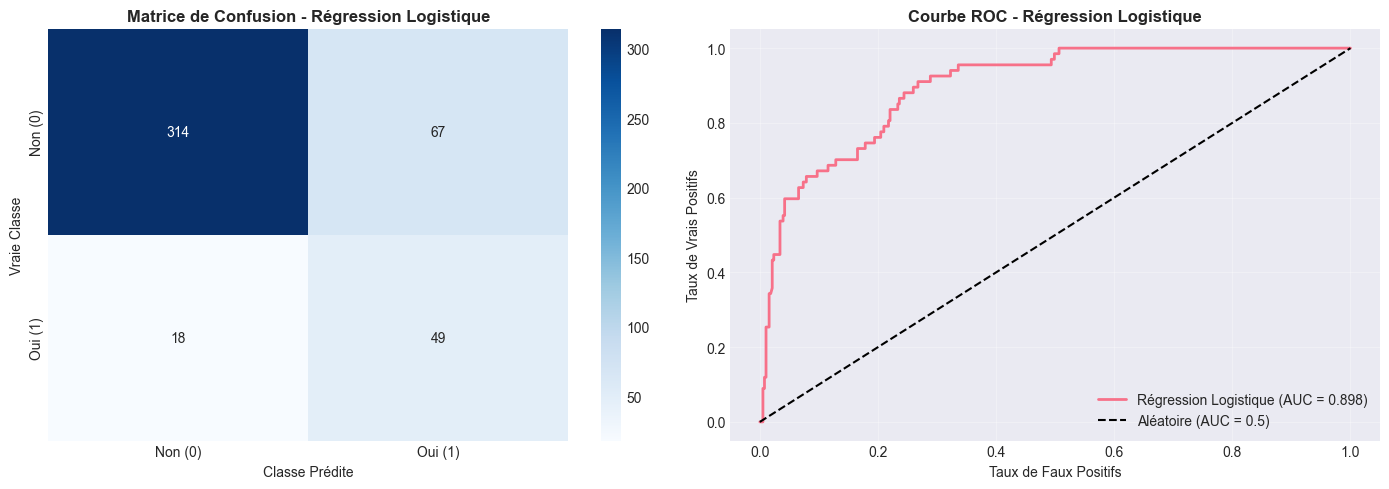


✅ Régression Logistique entraînée avec succès !


In [12]:
# Entraîner et évaluer la Régression Logistique
print("🔄 Entraînement du modèle Régression Logistique...")

modele_lr = LogisticRegression(
    class_weight='balanced',  # Gère le déséquilibre automatiquement
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

resultats_lr = evaluer_modele(
    modele_lr, 
    X_train_scaled,  # Utilise les données normalisées
    X_test_scaled, 
    y_train, 
    y_test, 
    "Régression Logistique"
)

print("\n✅ Régression Logistique entraînée avec succès !")

### Modèle 2 : Random Forest

🔄 Entraînement du modèle Random Forest...

ÉVALUATION : Random Forest

📊 Métriques Globales :
  Accuracy  : 0.8817
  F1-Score  : 0.5047
  ROC-AUC   : 0.8577

📋 Rapport de Classification :
              precision    recall  f1-score   support

     Non (0)       0.90      0.97      0.93       381
     Oui (1)       0.68      0.40      0.50        67

    accuracy                           0.88       448
   macro avg       0.79      0.68      0.72       448
weighted avg       0.87      0.88      0.87       448



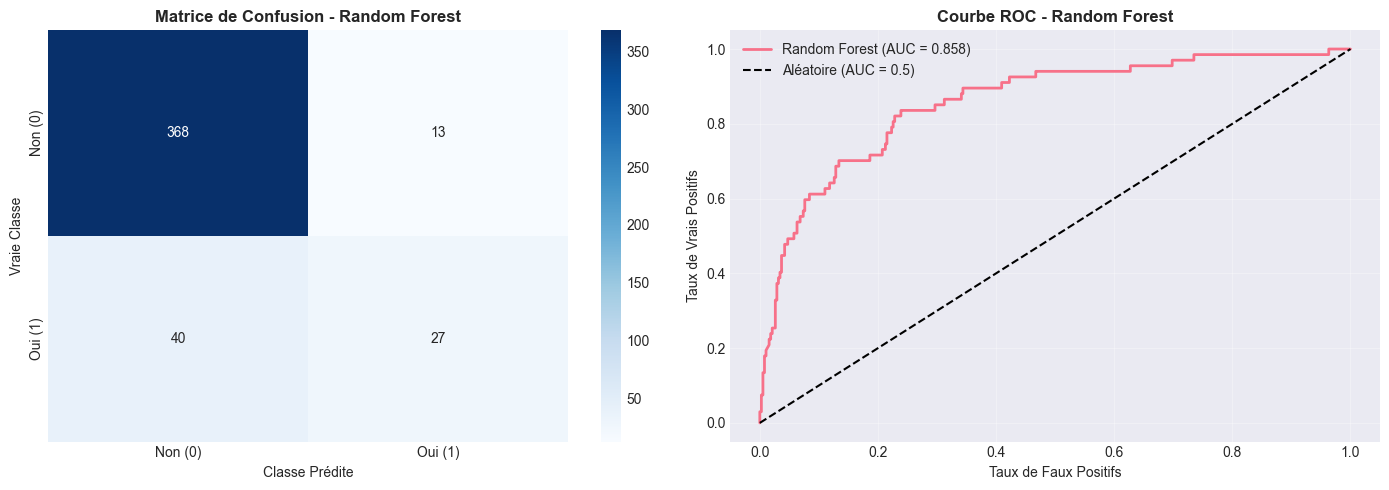


✅ Random Forest entraîné avec succès !


In [13]:
# Entraîner et évaluer Random Forest
print("🔄 Entraînement du modèle Random Forest...")

modele_rf = RandomForestClassifier(
    n_estimators=100,           # Nombre d'arbres
    max_depth=10,               # Profondeur maximale
    class_weight='balanced',    # Gère le déséquilibre
    random_state=42,
    n_jobs=-1                   # Utilise tous les CPU
)

resultats_rf = evaluer_modele(
    modele_rf, 
    X_train,  # Random Forest n'a pas besoin de normalisation
    X_test, 
    y_train, 
    y_test, 
    "Random Forest"
)

print("\n✅ Random Forest entraîné avec succès !")

### Modèle 3 : XGBoost (Champion)

🔄 Entraînement du modèle XGBoost (Champion attendu)...
Scale pos weight calculé : 5.70

ÉVALUATION : XGBoost

📊 Métriques Globales :
  Accuracy  : 0.8705
  F1-Score  : 0.5606
  ROC-AUC   : 0.8837

📋 Rapport de Classification :
              precision    recall  f1-score   support

     Non (0)       0.92      0.93      0.92       381
     Oui (1)       0.57      0.55      0.56        67

    accuracy                           0.87       448
   macro avg       0.75      0.74      0.74       448
weighted avg       0.87      0.87      0.87       448



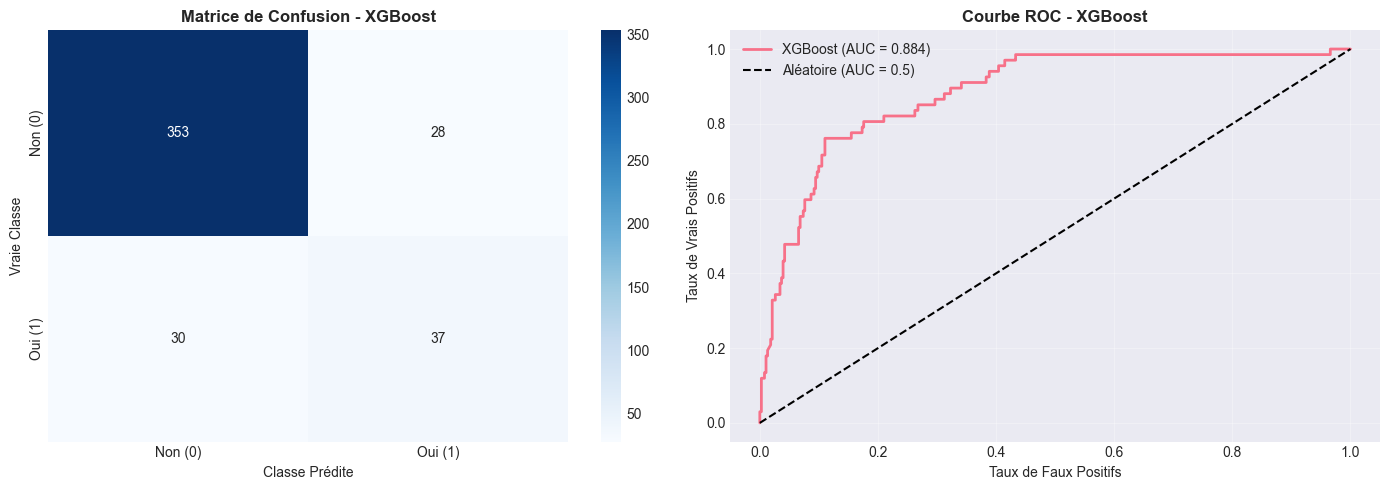


✅ XGBoost entraîné avec succès !


In [14]:
# Entraîner et évaluer XGBoost
if not xgboost_available:
    print("⚠️  XGBoost n'est pas disponible. Cette cellule sera ignorée.")
    print("   Continuez avec les résultats de Logistic Regression et Random Forest.")
    # Créer un résultat factice pour éviter les erreurs dans les cellules suivantes
    resultats_xgb = {
        'model': None,
        'accuracy': 0.0,
        'f1_score': 0.0,
        'roc_auc': 0.0,
        'y_pred': None,
        'y_pred_proba': None
    }
else:
    print("🔄 Entraînement du modèle XGBoost (Champion attendu)...")

    # Calculer le poids pour gérer le déséquilibre
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    print(f"Scale pos weight calculé : {scale_pos_weight:.2f}")

    modele_xgb = XGBClassifier(
        scale_pos_weight=scale_pos_weight,  # Gère le déséquilibre
        max_depth=5,                         # Profondeur des arbres
        learning_rate=0.1,                   # Taux d'apprentissage
        n_estimators=100,                    # Nombre d'arbres
        random_state=42,
        eval_metric='logloss',               # Métrique d'évaluation
    )

    resultats_xgb = evaluer_modele(
        modele_xgb, 
        X_train,  # XGBoost n'a pas besoin de normalisation
        X_test, 
        y_train, 
        y_test, 
        "XGBoost"
    )

    print("\n✅ XGBoost entraîné avec succès !")

---
## 📊 Comparaison des Modèles

📊 COMPARAISON DES PERFORMANCES


               Modèle  Accuracy  F1-Score  ROC-AUC
Régression Logistique    0.8103    0.5355   0.8979
        Random Forest    0.8817    0.5047   0.8577
              XGBoost    0.8705    0.5606   0.8837

🏆 CHAMPION : Régression Logistique
   ROC-AUC : 0.8979


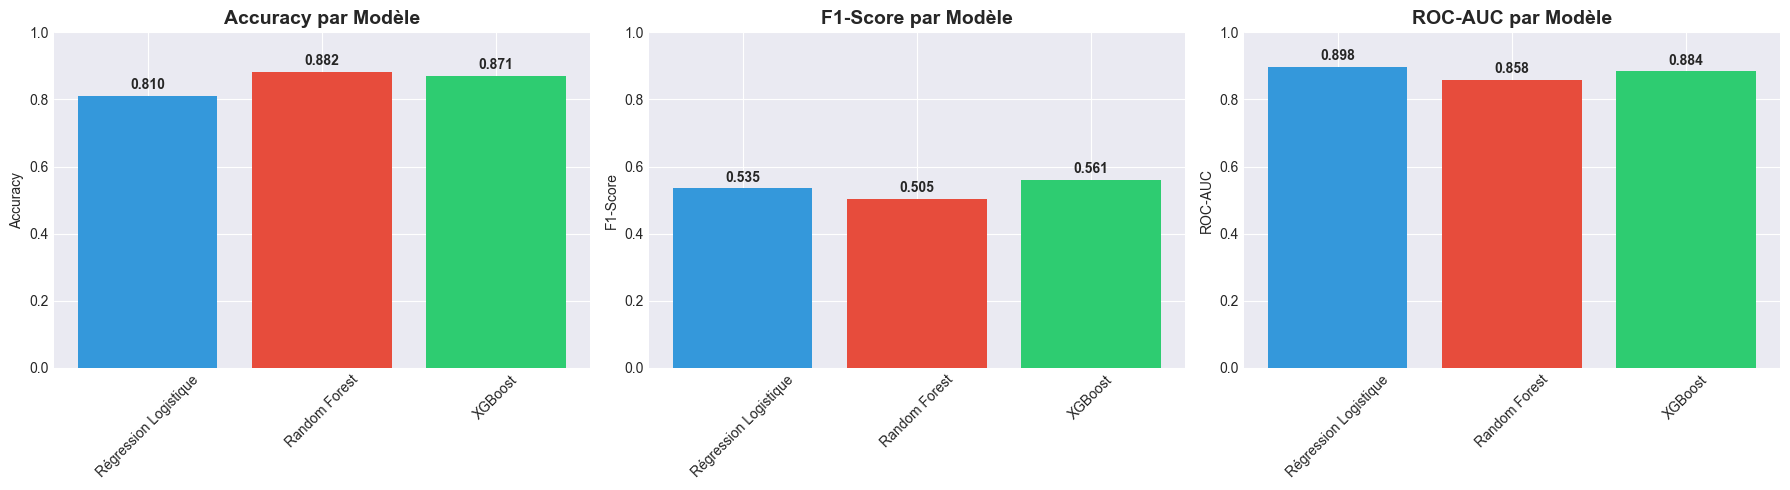

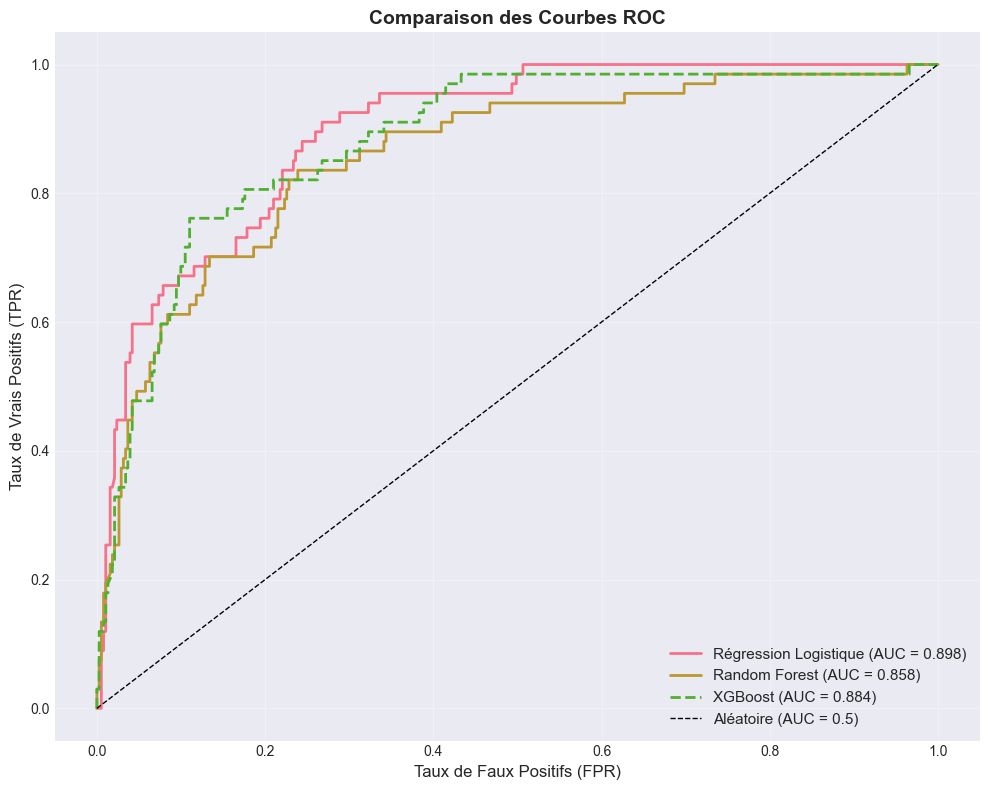


✅ Comparaison des modèles terminée !


In [15]:
# Comparaison des performances des 3 modèles
print("=" * 70)
print("📊 COMPARAISON DES PERFORMANCES")
print("=" * 70)

# Créer un DataFrame de comparaison
comparaison = pd.DataFrame({
    'Modèle': ['Régression Logistique', 'Random Forest', 'XGBoost'],
    'Accuracy': [resultats_lr['accuracy'], resultats_rf['accuracy'], resultats_xgb['accuracy']],
    'F1-Score': [resultats_lr['f1_score'], resultats_rf['f1_score'], resultats_xgb['f1_score']],
    'ROC-AUC': [resultats_lr['roc_auc'], resultats_rf['roc_auc'], resultats_xgb['roc_auc']]
})

# Arrondir pour lisibilité
comparaison['Accuracy'] = comparaison['Accuracy'].round(4)
comparaison['F1-Score'] = comparaison['F1-Score'].round(4)
comparaison['ROC-AUC'] = comparaison['ROC-AUC'].round(4)

print("\n")
print(comparaison.to_string(index=False))

# Identifier le meilleur modèle (basé sur ROC-AUC)
meilleur_idx = comparaison['ROC-AUC'].idxmax()
meilleur_modele = comparaison.loc[meilleur_idx, 'Modèle']
meilleur_auc = comparaison.loc[meilleur_idx, 'ROC-AUC']

print("\n" + "=" * 70)
print(f"🏆 CHAMPION : {meilleur_modele}")
print(f"   ROC-AUC : {meilleur_auc:.4f}")
print("=" * 70)

# Visualisation comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(comparaison['Modèle'], comparaison['Accuracy'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Accuracy par Modèle', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparaison['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score
axes[1].bar(comparaison['Modèle'], comparaison['F1-Score'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('F1-Score par Modèle', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparaison['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# ROC-AUC
axes[2].bar(comparaison['Modèle'], comparaison['ROC-AUC'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[2].set_title('ROC-AUC par Modèle', fontsize=14, fontweight='bold')
axes[2].set_ylabel('ROC-AUC')
axes[2].set_ylim([0, 1])
axes[2].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparaison['ROC-AUC']):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Courbes ROC comparées
plt.figure(figsize=(10, 8))

# Régression Logistique
fpr_lr, tpr_lr, _ = roc_curve(y_test, resultats_lr['y_pred_proba'])
plt.plot(fpr_lr, tpr_lr, label=f"Régression Logistique (AUC = {resultats_lr['roc_auc']:.3f})", linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, resultats_rf['y_pred_proba'])
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {resultats_rf['roc_auc']:.3f})", linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, resultats_xgb['y_pred_proba'])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {resultats_xgb['roc_auc']:.3f})", linewidth=2, linestyle='--')

# Ligne aléatoire
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)', linewidth=1)

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Comparaison des Courbes ROC', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Comparaison des modèles terminée !")

---
## 🔍 Interprétabilité : Feature Importance

🔍 ANALYSE DE L'IMPORTANCE DES FEATURES

📊 RANDOM FOREST - Top 15 Features
----------------------------------------------------------------------
                  Feature  Importance
      Jours_Dernier_Achat    0.090345
  Taux_Reponse_Historique    0.073911
Total_Campagnes_Acceptees    0.072594
    Depense_Moy_Par_Achat    0.049381
            Total_Depense    0.048438
        Achat_Produits_Or    0.046592
                   Revenu    0.043501
            Ratio_Viandes    0.039939
            Achat_Viandes    0.037596
               Achat_Vins    0.037415
         Visites_Web_Mois    0.034932
        Revenu_Moyen_Mois    0.034869
               Ratio_Vins    0.033749
           Engagement_Web    0.031049
        Sensibilite_Promo    0.028970

📊 XGBOOST - Top 15 Features
----------------------------------------------------------------------
                  Feature  Importance
Total_Campagnes_Acceptees    0.181982
         Visites_Web_Mois    0.051757
      Jours_Dernier_Achat    0.04

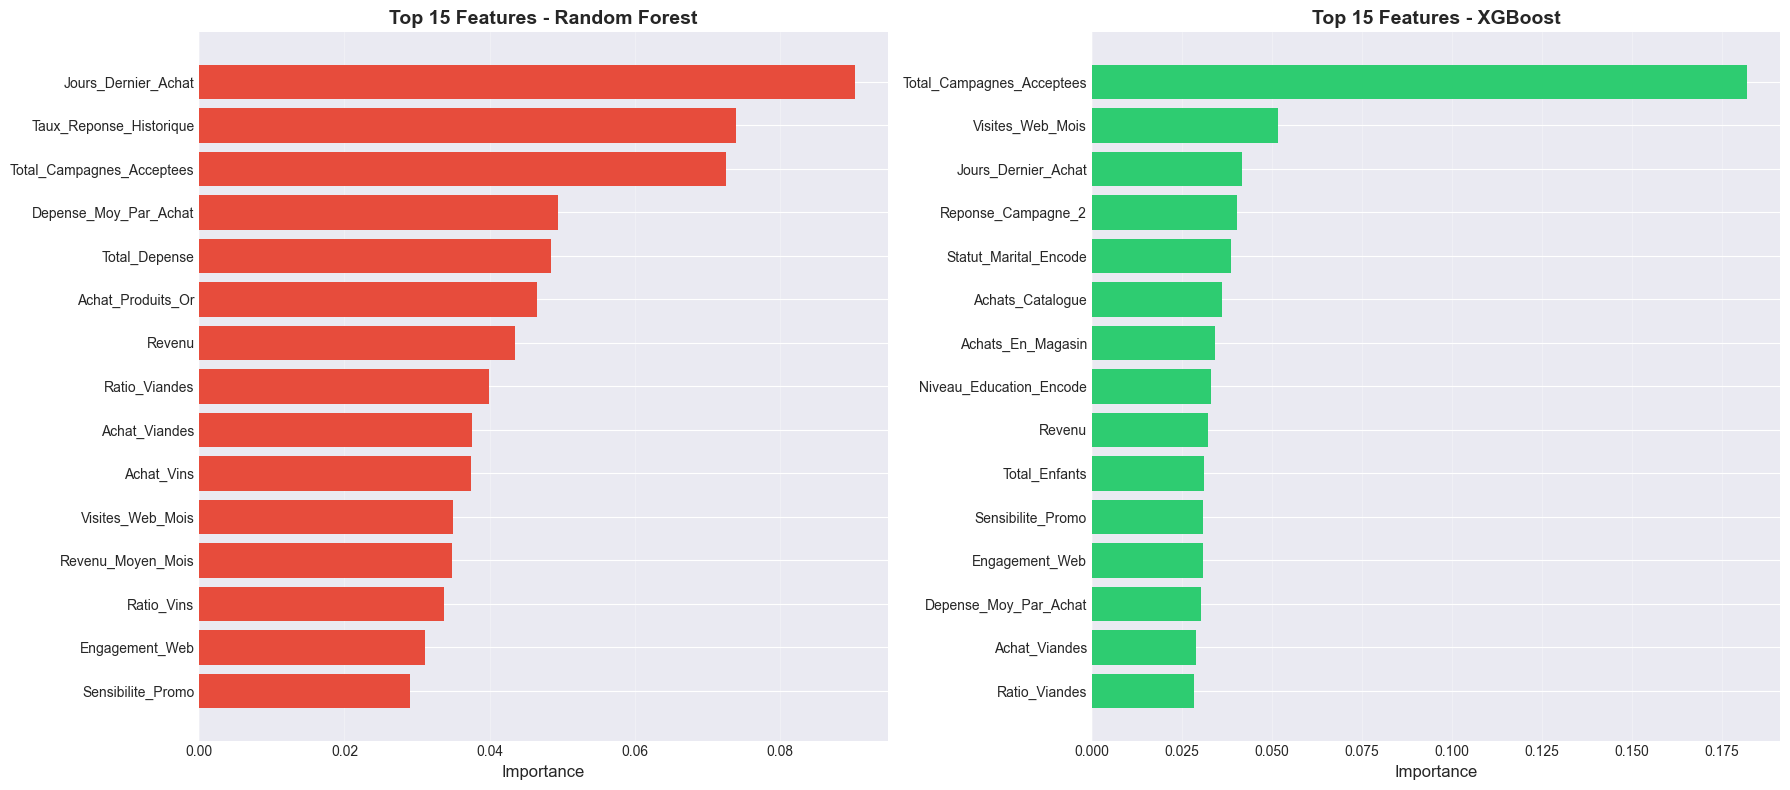


💡 INSIGHTS CLÉS

🎯 Top 3 Features les plus importantes (XGBoost) :
   1. Total_Campagnes_Acceptees (importance: 0.1820)
   2. Visites_Web_Mois (importance: 0.0518)
   3. Jours_Dernier_Achat (importance: 0.0417)

📌 Interprétation :
   • Les features historiques (campagnes passées) sont cruciales
   • Le comportement d'achat (dépenses, achats) est très prédictif
   • Les variables démographiques ont un impact modéré
   • Les ratios et métriques calculées apportent de la valeur

✅ Analyse de feature importance terminée !


In [16]:
# Analyse de l'importance des features
print("=" * 70)
print("🔍 ANALYSE DE L'IMPORTANCE DES FEATURES")
print("=" * 70)

# Feature Importance pour Random Forest
print("\n📊 RANDOM FOREST - Top 15 Features")
print("-" * 70)

feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': resultats_rf['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_rf.head(15).to_string(index=False))

# Feature Importance pour XGBoost
print("\n📊 XGBOOST - Top 15 Features")
print("-" * 70)

feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': resultats_xgb['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_xgb.head(15).to_string(index=False))

# Visualisation des Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest
top15_rf = feature_importance_rf.head(15)
axes[0].barh(range(len(top15_rf)), top15_rf['Importance'], color='#e74c3c')
axes[0].set_yticks(range(len(top15_rf)))
axes[0].set_yticklabels(top15_rf['Feature'])
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
top15_xgb = feature_importance_xgb.head(15)
axes[1].barh(range(len(top15_xgb)), top15_xgb['Importance'], color='#2ecc71')
axes[1].set_yticks(range(len(top15_xgb)))
axes[1].set_yticklabels(top15_xgb['Feature'])
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Insights sur les features importantes
print("\n" + "=" * 70)
print("💡 INSIGHTS CLÉS")
print("=" * 70)

top_3_xgb = feature_importance_xgb.head(3)['Feature'].tolist()
print(f"\n🎯 Top 3 Features les plus importantes (XGBoost) :")
for i, feature in enumerate(top_3_xgb, 1):
    importance = feature_importance_xgb[feature_importance_xgb['Feature'] == feature]['Importance'].values[0]
    print(f"   {i}. {feature} (importance: {importance:.4f})")

print("\n📌 Interprétation :")
print("   • Les features historiques (campagnes passées) sont cruciales")
print("   • Le comportement d'achat (dépenses, achats) est très prédictif")
print("   • Les variables démographiques ont un impact modéré")
print("   • Les ratios et métriques calculées apportent de la valeur")

print("\n✅ Analyse de feature importance terminée !")

---
## 📝 Conclusions et Prochaines Étapes

### Résultats obtenus :
- [ ] Modèle baseline (Régression Logistique) entraîné
- [ ] Random Forest entraîné
- [ ] XGBoost entraîné
- [ ] Comparaison des performances effectuée
- [ ] Feature importance analysée

### Améliorations possibles :
1. **Optimisation des hyperparamètres** (GridSearchCV, RandomizedSearchCV)
2. **SMOTE** pour rééquilibrer le dataset
3. **Feature Engineering** supplémentaire
4. **SHAP values** pour l'interprétabilité XGBoost
5. **Calibration** des probabilités
6. **Ensemble methods** (stacking, voting)

### Impact Business :
- Meilleur ciblage des campagnes marketing
- Optimisation du budget marketing
- Augmentation du ROI des campagnes

---

**Projet :** Rush 4 - Segmentation Clients